In [2]:
%%HTML
<style>
p {
    color: #343a40;
}

h1 a.anchor-link {
    color: #F7ECCB;
}

h1 {
    background-color: #343a40;
    width: fit-content;
    padding: 15px;
    color: white;
    text-align: center;
    width: 100%;
}

.intro {
    width: 60%;
    margin: auto;
    text-align: justify !important;
    font-family: Georgia;
}

.output_png {
    display: flex;
    align-items: center;
    justify-content: center;
}

.hide_btn {
    background-color: #343a40;
    padding: 15px;
    color: white;
    border-radius: 30px;
    border: none;
}
</style>

In [3]:
%%HTML
<script>
    code_show=true;
    function code_toggle() {
         if (code_show){
             $('div.input').hide();
         } else {
             $('div.input').show();
         }
         code_show = !code_show
    }
    $( document ).ready(code_toggle);
</script>
<form action="javascript:code_toggle()">
    <input class='hide_btn' type="submit"
    value="Toggle code">
</form>

In [4]:
import os
os.environ['SKIMAGE_DATADIR'] = '/tmp/.skimage_cache'

In [5]:
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

In [18]:
from skimage.io import imread, imshow
from skimage.transform import downscale_local_mean
from skimage.color import rgb2gray, rgb2hsv, gray2rgb
from skimage import img_as_ubyte, img_as_float
from skimage.exposure import histogram, cumulative_distribution
from skimage.morphology import closing, opening, area_closing, area_opening, erosion, dilation
from skimage.measure import label, regionprops

In [22]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle
from scipy.stats import norm
from scipy.signal import convolve2d

# Chapter 4: Of blood and blobs

<p class='intro'><br>Dear diary,<br>
My heart is beating so fast right now. I can’t believe what I just did. I almost got caught. But it doesn't matter. I got what I needed. <b>Don’t</b>. Don’t ask me how I got it. Don’t ask how his blood came to flow like my love for him. Don’t worry, he’s safe. And there’s no way to trace it to me. But he may never feel safe in that coffee shop again. But he doesn’t know that he doesn’t have to be scared.
</p>
<p class='intro'><i>I would kill for him.</i></p>

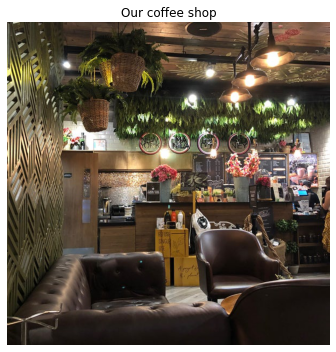

In [30]:
ch4 = imread('images/ch4.jpg')
plt.figure(figsize=(20, 5))
plt.axis('off')
plt.title('Our coffee shop')
plt.tight_layout()
plt.imshow(ch4);

With his blood under my microscope, he feels so near. I feel so close to him. They say you can tell a lot about a person based on their blood. Japanese culture even has personality archetypes assigned to each blood type. So, why don't we start with a count?

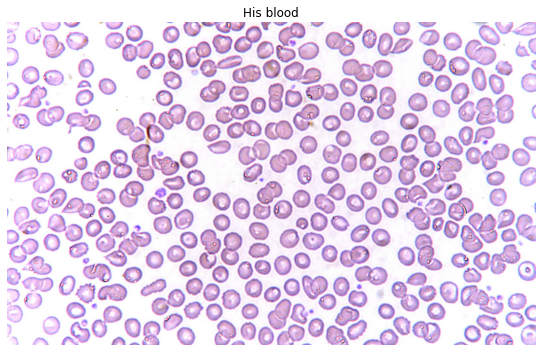

In [11]:
blood = imread('images/rbc.jpg')
plt.figure(figsize=(20, 5))
plt.axis('off')
plt.title('His blood')
plt.tight_layout()
plt.imshow(blood);

It's once again trial and error as I try to find a suitable threshold to binarize the image with. Selecting the right threshold can mean the difference between properly segmented cells and not. This is one of the steps to take to get better segmentation. But I found the right threshold in the end, and I have my binarized image.

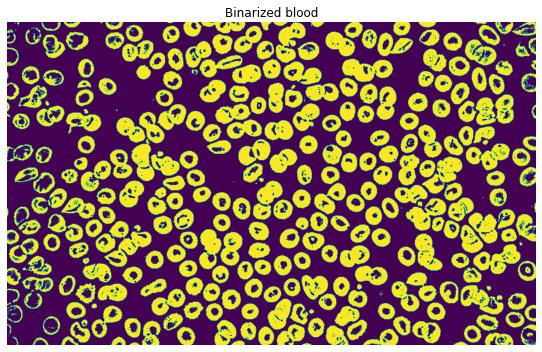

In [15]:
im = rgb2gray(blood)
im_bw = (im<0.5)*1
im_mask = im < 0.8
plt.figure(figsize=(20, 5))
plt.axis('off')
plt.title('Binarized blood')
plt.tight_layout()
plt.imshow(im_mask*1);

The next step is to clean up the image, like I cleaned up that coffee shop after I was done with what I did. There are some cells in this blood sample that should be separated. And there are some dots and blobs as well, that don't look like red blood cells. Those should disappear. A series of area openings and closings, where multiple erosions and dilations are occuring, was applied to clean up the image.

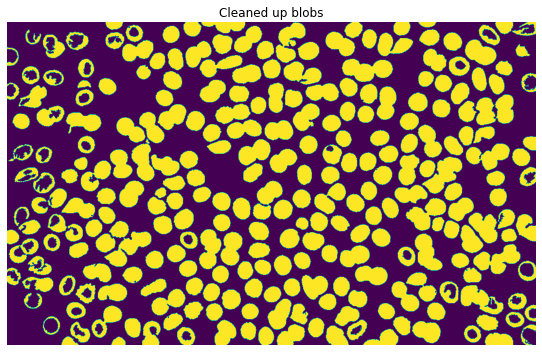

In [29]:
im_cleaned = area_closing(area_opening(im_mask*1,250),250)
plt.figure(figsize=(20, 5))
plt.axis('off')
plt.title('Cleaned up blobs')
plt.tight_layout()
plt.imshow(im_cleaned);

Now, we have the image cleaned up, great. The next step is to label each separate blob. We can use the label function for that.

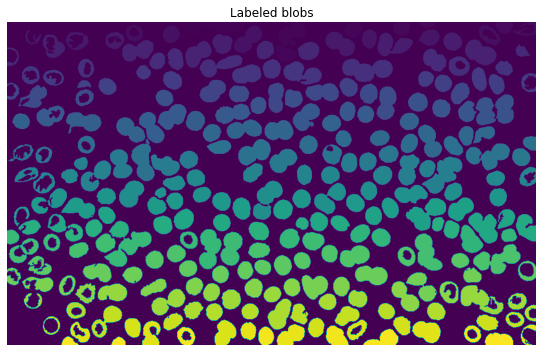

In [20]:
label_im = label(im_cleaned)
plt.figure(figsize=(20, 5))
plt.axis('off')
plt.title('Labeled blobs')
plt.tight_layout()
plt.imshow(label_im);

Once the labels have been applied to the blobs, it's time to get their props. Props are blob properties such as area, width, and height, among others. Now, what would be a good property to differentiate those weirder shaped blobs fromt the normal ones? Oh, I know. We can use the area of these blobs.

In [33]:
props = regionprops(label_im)

area_list = []
for prop in props:
    area_list.append(prop.area)

df_cell_area = pd.DataFrame(area_list)

area_stats = df_cell_area.describe()

print('Blob Area Statistics')
display(area_stats)

Blob Area Statistics


,0
count,264.000000
mean,1219.155303
std,587.998347
min,263.000000
25%,900.250000
50%,1062.000000
75%,1457.250000
max,3356.000000


We can filter out the bigger blobs to get a better count of the individual red blood cells. Using the 75th percentile is sufficient for our purposes. Hmmm. It seems that he has a healthy smattering of red blood cells. Good for him.

Individual Red Blood Cell Count: 198


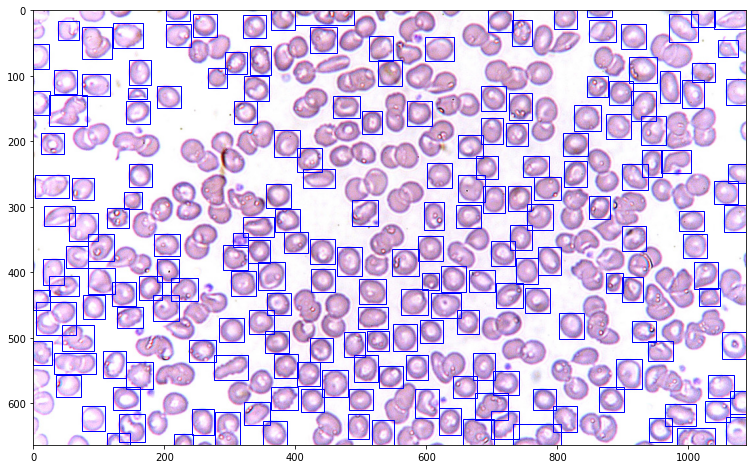

In [26]:
double_sep = int(area_stats.loc['75%'])

fig, ax = plt.subplots(figsize=(18, 8))

ax.imshow(blood)
indiv_rbc_count = 0

for i, prop in enumerate(filter(lambda x: x.area < double_sep, props)):
    y1, x1, y2, x2 = (prop.bbox[0], prop.bbox[1],
                      prop.bbox[2], prop.bbox[3])
    width = x2 - x1
    height = y2 - y1
    r = plt.Rectangle((x1, y1), width = width, height=height,
                      color='b', fill=False)
    ax.add_patch(r)
    indiv_rbc_count += 1
print('Individual Red Blood Cell Count:', indiv_rbc_count)

And here we have the irregulars: cells right next to each other. Cells attached to another. But is that really so irregular? So what if I want to be by his side every second of every day? Is that so wrong?

Red Blood Cell Count: 66


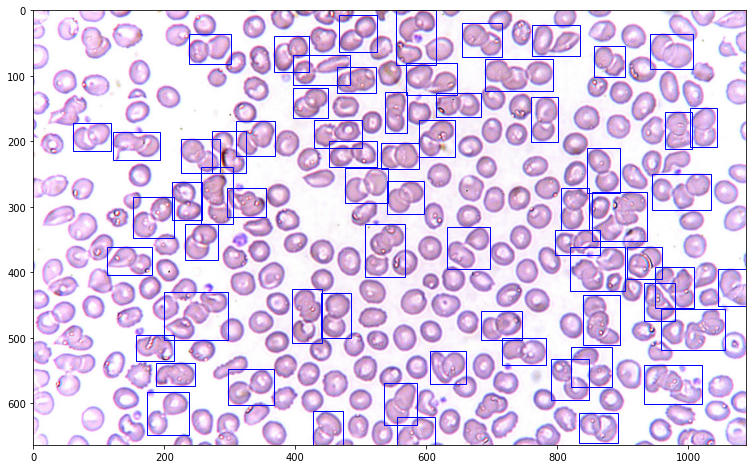

In [28]:
fig, ax = plt.subplots(figsize=(18, 8))

ax.imshow(blood)
multi_rbc_count = 0

for i, prop in enumerate(filter(lambda x: x.area >= double_sep, props)):
    y1, x1, y2, x2 = (prop.bbox[0], prop.bbox[1],
                      prop.bbox[2], prop.bbox[3])
    width = x2 - x1
    height = y2 - y1
    r = plt.Rectangle((x1, y1), width = width, height=height,
                      color='b', fill=False)
    ax.add_patch(r)
    multi_rbc_count += 1
print('Red Blood Cell Count:', multi_rbc_count)

<p class='intro'>Things are getting really tense. And I'm worried that with the coffee shop out of the picture, we're out of ways to <i>bump</i> into each other. I wonder what I should do next. Maybe I can follow him home, and find out where he lives.</p>
<p class='intro'><i>I'm not one of those crazy girls, I swear. xoxo</i></p>